# Importing Libraries

In [1]:
!pip install split_folders

In [16]:
# Libraries Required
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import splitfolders
import pandas as pd
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, RandomCrop, RandomContrast,Rescaling, MaxPool2D, Conv2D
from tensorflow.keras.applications import EfficientNetB5, Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data 

## Loading Data

In [4]:
! conda install -y gdown # comment this line if you are working in Colab

#! gdown 1tPlYzd6WsM32b0JzELd8zTTO7JHckL5q No Longer Available
# Download Dataset From https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af
# Their github https://github.com/tampapath/lung_colon_image_set/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.7.1               |  py310hff52083_0         940 KB  conda-forge
    filelock-3.15.4            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.1              |       h4bc722e_2         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.15.4-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdow

In [5]:
!unzip /kaggle/working/LC25000.zip

Archive:  /kaggle/working/LC25000.zip
   creating: lung_colon_image_set/
   creating: lung_colon_image_set/lung_image_sets/
   creating: lung_colon_image_set/lung_image_sets/lung_aca/
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca57.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca458.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca556.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca639.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca678.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca684.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca688.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca687.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca762.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_aca/lungaca765.jpeg  
  inflating: lung_colon_image_set/lung_image_se

In [6]:
!mv /kaggle/working/lung_colon_image_set/colon_image_sets/colon_n /kaggle/working/lung_colon_image_set/lung_image_sets/colon_n
!mv /kaggle/working/lung_colon_image_set/colon_image_sets/colon_aca /kaggle/working/lung_colon_image_set/lung_image_sets/colon_aca

## Constants

In [7]:
# Constants
IMAGE_SIZE = 768
BATCH_SIZE = 64
RANDOM_STATE = 42

## Loading Data From Directory

In [8]:
data = image_dataset_from_directory(
    "/kaggle/working/lung_colon_image_set/lung_image_sets",
    seed= RANDOM_STATE,
    shuffle= True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 5 classes.


# Data Exploration

In [8]:
class_names = data.class_names
class_names

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [9]:
len(data)

391

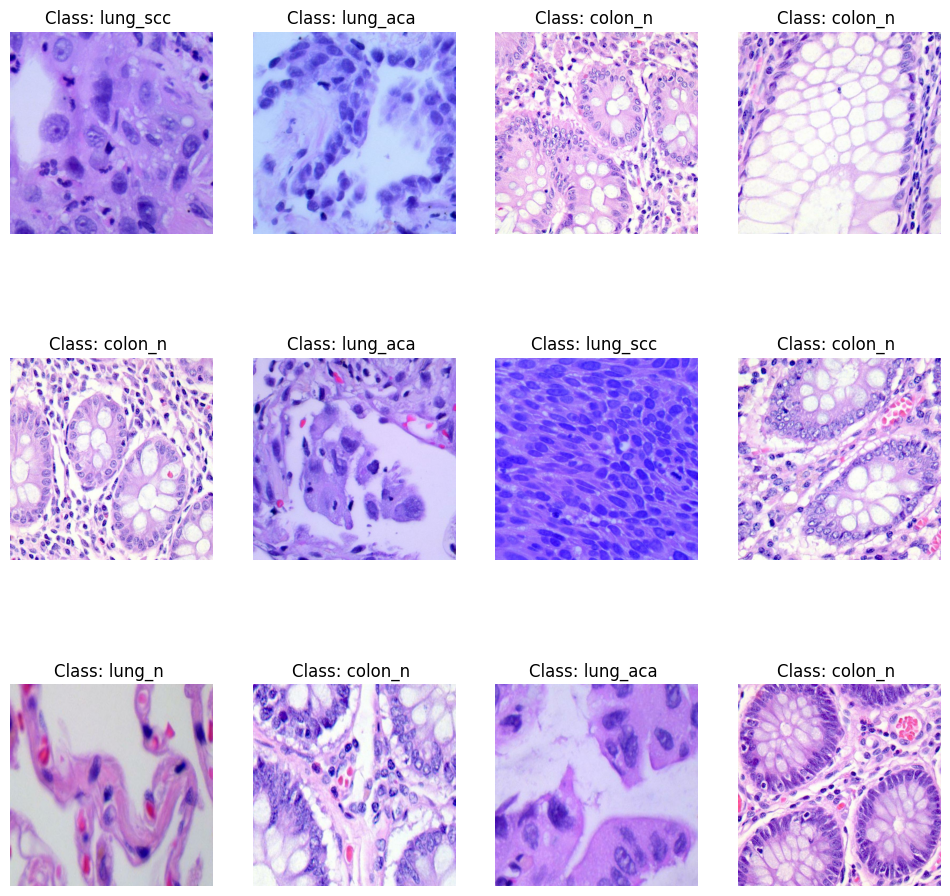

In [10]:
plt.figure(figsize = (12,12))
for image_batch, image_label in data.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(f"Class: {class_names[image_label[i].numpy()]} ")
    plt.axis("off")

# Preparing Data For Training

In [9]:
splitfolders.ratio('/kaggle/working/lung_colon_image_set/lung_image_sets/', output="data", seed= RANDOM_STATE , ratio=(.7, 0.2,0.1))

Copying files: 25000 files [00:05, 4606.59 files/s]


In [12]:
train = image_dataset_from_directory(
    "/kaggle/working/data/train",
    seed= RANDOM_STATE,
    shuffle= True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 17500 files belonging to 5 classes.


In [13]:
val = image_dataset_from_directory(
    '/kaggle/working/data/val',
    seed = RANDOM_STATE,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 5000 files belonging to 5 classes.


In [10]:
test = image_dataset_from_directory(
    '/kaggle/working/data/test',
    seed = RANDOM_STATE,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2500 files belonging to 5 classes.


# Model 

## Model Function

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_135CLONE           │ (None, 299, 299, 3)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │     1,024,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,885,485 (83.49 MB)

 Trainable params: 1,024,005 (3.91 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Training

In [18]:
def get_model(ds_input_shape, base_model_input_shape, model_name):
    if model_name.lower() == 'xception': 
        base_model = Xception(include_top=False, weights='imagenet', input_shape=base_model_input_shape)
    else:
        base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=base_model_input_shape)
        
    base_model.trainable = False
    inp = Input(ds_input_shape)
    
    if model_name.lower() == 'xception':
        resized_inp = Resizing(299, 299)(inp)
        preprocessed_inp = tf.keras.applications.xception.preprocess_input(resized_inp)
        for layer in base_model.layers[126:]:
            layer.trainable = True
    else:
        resized_inp = Resizing(456, 456)(inp)
        preprocessed_inp = tf.keras.applications.efficientnet.preprocess_input(resized_inp)
        for layer in base_model.layers[559:]:
            layer.trainable = True
    
    
    x = base_model(preprocessed_inp)
    x = Flatten()(x)
    x = Dense(32, activation = "swish", kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs=inp, outputs=outputs)
    return model

In [19]:
ds_inp_shape = [768, 768, 3]
md_inp_shape = [299, 299, 3] 
xcep_model = get_model(ds_inp_shape, md_inp_shape, 'xception')


In [20]:
learning_rate_schedule = ExponentialDecay(
    initial_learning_rate= 0.0001,
    decay_steps= 5500,
    decay_rate=0.96
)

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta = 0.05 ,patience= 4,
                                            verbose = 1, baseline = 0.98,restore_best_weights=True
                                           , mode = "max")

In [39]:
xcep_model.compile(optimizer= Adam(learning_rate = learning_rate_schedule),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [40]:
history = xcep_model.fit(
    train,
    batch_size=BATCH_SIZE,
    validation_data=val,
    verbose=1,
    epochs= 25,
    callbacks=[callback]
)


Epoch 1/25


W0000 00:00:1722693308.526559     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9993

W0000 00:00:1722693451.035832     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 188s 652ms/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0090 - val_sparse_categorical_accuracy: 0.9984
Epoch 2/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 169s 619ms/step - loss: 0.0050 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0261 - val_sparse_categorical_accuracy: 0.9960
Epoch 3/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 170s 619ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0173 - val_sparse_categorical_accuracy: 0.9972
Epoch 4/25
274/274 ━━━━━━━━━━━━━━━━━━━━ 169s 618ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.0248 - val_sparse_categorical_accuracy: 0.9948
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


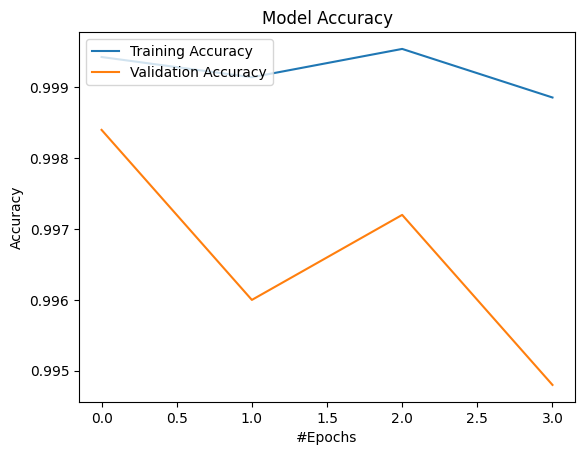

In [41]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('#Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

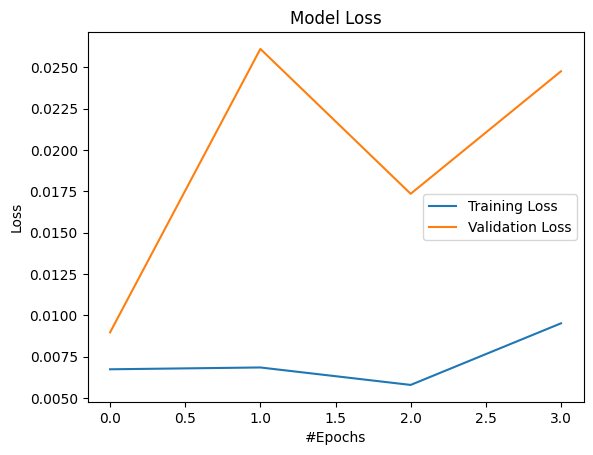

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss', 'Validation Loss'])

In [43]:
ds_inp_shape = [768, 768, 3]
md_inp_shape = [456, 456, 3] 
enet_model = get_model(ds_inp_shape, md_inp_shape, 'efficientnet')

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [45]:
enet_model.compile(optimizer= Adam(learning_rate = learning_rate_schedule),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [46]:
enet_history = xcep_model.fit(
    train,
    batch_size=BATCH_SIZE,
    validation_data=val,
    verbose=1,
    epochs= 5,
    callbacks=[callback]
)


Epoch 1/5


W0000 00:00:1722694096.976071     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9991

W0000 00:00:1722694239.629122     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 188s 652ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0103 - val_sparse_categorical_accuracy: 0.9980
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 169s 618ms/step - loss: 0.0026 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0068 - val_sparse_categorical_accuracy: 0.9986
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 169s 619ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0150 - val_sparse_categorical_accuracy: 0.9986
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 170s 619ms/step - loss: 0.0092 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 0.9980
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


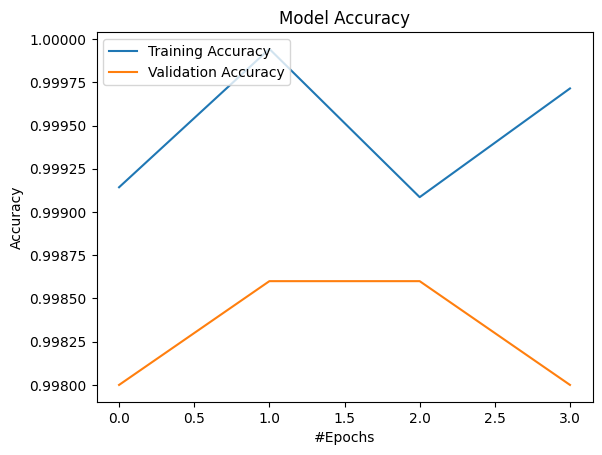

In [51]:
plt.plot(enet_history.history['sparse_categorical_accuracy'])
plt.plot(enet_history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('#Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

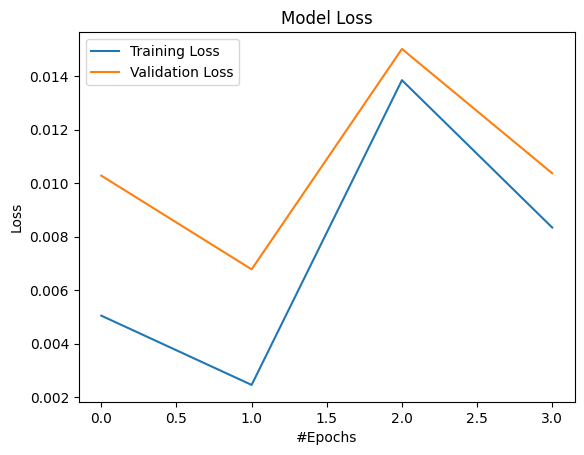

In [52]:
plt.plot(enet_history.history['loss'])
plt.plot(enet_history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss', 'Validation Loss'])

## Evaluation

### Xception Model Generalization Error

In [54]:
results = xcep_model.evaluate(test)
results

40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 603ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9979


[0.01195735577493906, 0.9976000189781189]

### MobileNetB5 Gneralization Error

In [59]:
results = enet_model.evaluate(test)
results

40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 2.0746 - sparse_categorical_accuracy: 0.1588


[2.0768842697143555, 0.16040000319480896]

### Classification Report

In [13]:
y_pred = []  
y_true = []  

for image_batch, label_batch in test:   
   y_true.append(label_batch.numpy())
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

1/2 ━━━━━━━━━━━━━━━━━━━━ 28s 29s/step

I0000 00:00:1723012331.149482     262 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723012331.185867     262 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

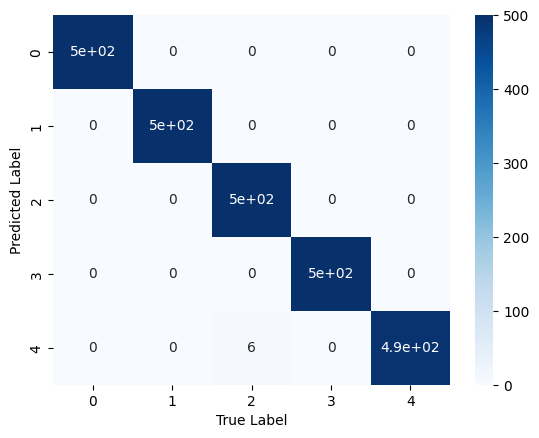

In [14]:
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel("True Label")
plt.ylabel('Predicted Label')
plt.savefig('Confusion Matrix')

In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       0.99      1.00      0.99       500
           3       1.00      1.00      1.00       500
           4       1.00      0.99      0.99       500

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



# Saving and Loading Model 

In [48]:
xcep_model.save('/kaggle/working/xcep_lc_model.keras')

In [49]:
enet_model.save('/kaggle/working/enet_lc_model.keras')

In [11]:
# Kindly download it from github: 
#! gdown 1967KLBKWYOSV2X5CsCRG6w9fvdABmCxE No longer Available
# 

Downloading...
From (original): https://drive.google.com/uc?id=1967KLBKWYOSV2X5CsCRG6w9fvdABmCxE
From (redirected): https://drive.google.com/uc?id=1967KLBKWYOSV2X5CsCRG6w9fvdABmCxE&confirm=t&uuid=d7e72c50-5d95-4fe5-ae60-274ce79747fe
To: /kaggle/working/xcep_lc_model.keras
100%|████████████████████████████████████████| 201M/201M [00:02<00:00, 72.5MB/s]


In [12]:
model = tf.keras.models.load_model('/kaggle/working/xcep_lc_model.keras')